# Importações

In [2]:
import xml.etree.ElementTree as xet
from glob import glob
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import precision_score, recall_score
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import random
import time

In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9952863549274901978
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10895294464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7633342872316704916
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2024-04-11 20:38:49.770191: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 20:38:49.786027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 20:38:50.122595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 20:38:50.122792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Tratando Dataset

In [3]:
!curl -L -o /tmp/tcc_alpd/archive.tar.gz "https://www.dropbox.com/scl/fi/khnnv0x8pcpbzlgfevqac/archive.tar.gz?rlkey=55w3pkxp02szjpqw22df7hmn8&dl=0"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    264      0 --:--:-- --:--:-- --:--:--   263
100   491    0   491    0     0    234      0 --:--:--  0:00:02 --:--:--   940
100  202M  100  202M    0     0  13.4M      0  0:00:15  0:00:15 --:--:-- 17.6M


In [4]:
!tar xfv /tmp/tcc_alpd/archive.tar.gz -C /tmp/tcc_alpd

archive/
archive/.DS_Store
archive/images/
archive/annotations/
archive/annotations/Cars213.xml
archive/annotations/Cars207.xml
archive/annotations/Cars398.xml
archive/annotations/Cars367.xml
archive/annotations/Cars401.xml
archive/annotations/Cars415.xml
archive/annotations/Cars373.xml
archive/annotations/Cars429.xml
archive/annotations/Cars47.xml
archive/annotations/Cars53.xml
archive/annotations/Cars165.xml
archive/annotations/Cars171.xml
archive/annotations/Cars159.xml
archive/annotations/Cars84.xml
archive/annotations/Cars90.xml
archive/annotations/Cars91.xml
archive/annotations/Cars85.xml
archive/annotations/Cars158.xml
archive/annotations/Cars170.xml
archive/annotations/Cars164.xml
archive/annotations/Cars52.xml
archive/annotations/Cars46.xml
archive/annotations/Cars428.xml
archive/annotations/Cars414.xml
archive/annotations/Cars372.xml
archive/annotations/Cars366.xml
archive/annotations/Cars400.xml
archive/annotations/Cars399.xml
archive/annotations/Cars206.xml
archive/annotati

In [3]:
IMAGE_PATH="/tmp/tcc_alpd/archive/images/"
ANNOTATIONS_PATH = "/tmp/tcc_alpd/archive/annotations/"

In [4]:
def generate_dataframe_from_xml_annotations(directory):
    path = glob(directory)
    labels_dict = dict(filepath=[], xmin=[], xmax=[], ymin=[], ymax=[])
    
    for filename in path:
        info = xet.parse(filename)
        root = info.getroot()
        member_object = root.find('object')
        labels_info = member_object.find('bndbox')
        xmin = int(labels_info.find('xmin').text)
        xmax = int(labels_info.find('xmax').text)
        ymin = int(labels_info.find('ymin').text)
        ymax = int(labels_info.find('ymax').text)

        labels_dict['filepath'].append(filename)
        labels_dict['xmin'].append(xmin)
        labels_dict['xmax'].append(xmax)
        labels_dict['ymin'].append(ymin)
        labels_dict['ymax'].append(ymax)

    df = pd.DataFrame(labels_dict)
    return df

def getFilename(filepath):
    filename_image = xet.parse(filepath).getroot().find('filename').text
    filepath_image = os.path.join(IMAGE_PATH, filename_image)
    return filepath_image

def get_image_paths_from_dataframe(df):
    return df['filepath'].apply(getFilename)

In [5]:
df = generate_dataframe_from_xml_annotations(ANNOTATIONS_PATH+'*.xml')
image_path = get_image_paths_from_dataframe(df)
df

filepath  xmin  xmax  ymin  ymax
0    /tmp/tcc_alpd/archive/annotations/Cars232.xml   175   228   174   201
1    /tmp/tcc_alpd/archive/annotations/Cars289.xml   163   271   140   173
2    /tmp/tcc_alpd/archive/annotations/Cars118.xml   193   394   165   217
3     /tmp/tcc_alpd/archive/annotations/Cars49.xml   268   314   171   190
4    /tmp/tcc_alpd/archive/annotations/Cars241.xml   126   241   142   199
..                                             ...   ...   ...   ...   ...
428  /tmp/tcc_alpd/archive/annotations/Cars210.xml    54   315    90   159
429   /tmp/tcc_alpd/archive/annotations/Cars70.xml   179   213   115   133
430  /tmp/tcc_alpd/archive/annotations/Cars329.xml   166   224   142   176
431  /tmp/tcc_alpd/archive/annotations/Cars192.xml   108   211   150   173
432  /tmp/tcc_alpd/archive/annotations/Cars332.xml   143   260   126   159

[433 rows x 5 columns]

In [6]:
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape

    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0

    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax)

    data.append(norm_load_image_arr)
    output.append(label_norm)

In [7]:
def split_train_test_data(processed_data, processed_output, train_size=0.8, random_state=None):
    X = np.array(processed_data, dtype=np.float32)
    y = np.array(processed_output, dtype=np.float32)

    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_train_test_data(data, output, train_size=0.8, random_state=0)
print("Tamanhos dos conjuntos de treino e teste:")
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Tamanhos dos conjuntos de treino e teste:
x_train shape: (346, 224, 224, 3)
x_test shape: (87, 224, 224, 3)
y_train shape: (346, 4)
y_test shape: (87, 4)


# Treinando Modelo

In [3]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
model = Model(inputs=inception_resnet.input,outputs=headmodel)

2024-04-16 20:28:35.529405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-16 20:28:35.594929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-16 20:28:35.595101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-16 20:28:35.596280: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [ ]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=50,
                    validation_data=(x_test,y_test))

Epoch 1/50


2024-04-11 18:31:20.548119: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8907
2024-04-11 18:31:21.386859: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


35/35 [==============================] - 22s 255ms/step - loss: 0.0342 - val_loss: 0.0356
Epoch 2/50
35/35 [==============================] - 5s 142ms/step - loss: 0.0117 - val_loss: 0.0203
Epoch 3/50
35/35 [==============================] - 5s 142ms/step - loss: 0.0084 - val_loss: 0.0165
Epoch 4/50
35/35 [==============================] - 5s 142ms/step - loss: 0.0079 - val_loss: 0.0177
Epoch 5/50
35/35 [==============================] - 5s 142ms/step - loss: 0.0038 - val_loss: 0.0161
Epoch 6/50
35/35 [==============================] - 5s 142ms/step - loss: 0.0036 - val_loss: 0.0201
Epoch 7/50
35/35 [==============================] - 5s 142ms/step - loss: 0.0035 - val_loss: 0.0148
Epoch 8/50
35/35 [==============================] - 5s 142ms/step - loss: 0.0026 - val_loss: 0.0132
Epoch 9/50
35/35 [==============================] - 5s 142ms/step - loss: 0.0023 - val_loss: 0.0130
Epoch 10/50
35/35 [==============================] - 5s 142ms/step - loss: 0.0020 - val_loss: 0.0124
Epoch 11/

In [11]:
model.save('./license_plate_detection.h5')

# Validando Modelo

In [2]:
model = tf.keras.models.load_model('./license_plate_detection.h5')

2024-04-16 18:55:36.392333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-16 18:55:39.151155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-16 18:55:39.151925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-16 18:55:39.160001: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [15]:
y_pred = model.predict(x_test)

2024-04-11 20:39:40.693155: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8907
2024-04-11 20:39:41.901941: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [16]:
y_test_flat = np.argmax(y_test, axis=1)
y_pred_flat = np.argmax(y_pred, axis=1)

precision = precision_score(y_test_flat, y_pred_flat, average='macro')
recall = recall_score(y_test_flat, y_pred_flat, average='macro')

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.8292158968850698
Recall: 0.8250265111346766


In [17]:
def object_detection(path):
    image = cv2.imread(path)
    h, w, d = image.shape
    
    image_arr_224 = img_to_array(load_img(path, target_size=(224, 224))) / 255.0  # Convert to array & normalized
    test_arr = image_arr_224.reshape(1, 224, 224, 3)
    
    coords = model.predict(test_arr)
    
    denorm = np.array([w, w, h, h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    xmin, xmax, ymin, ymax = coords[0]
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
    
    return image

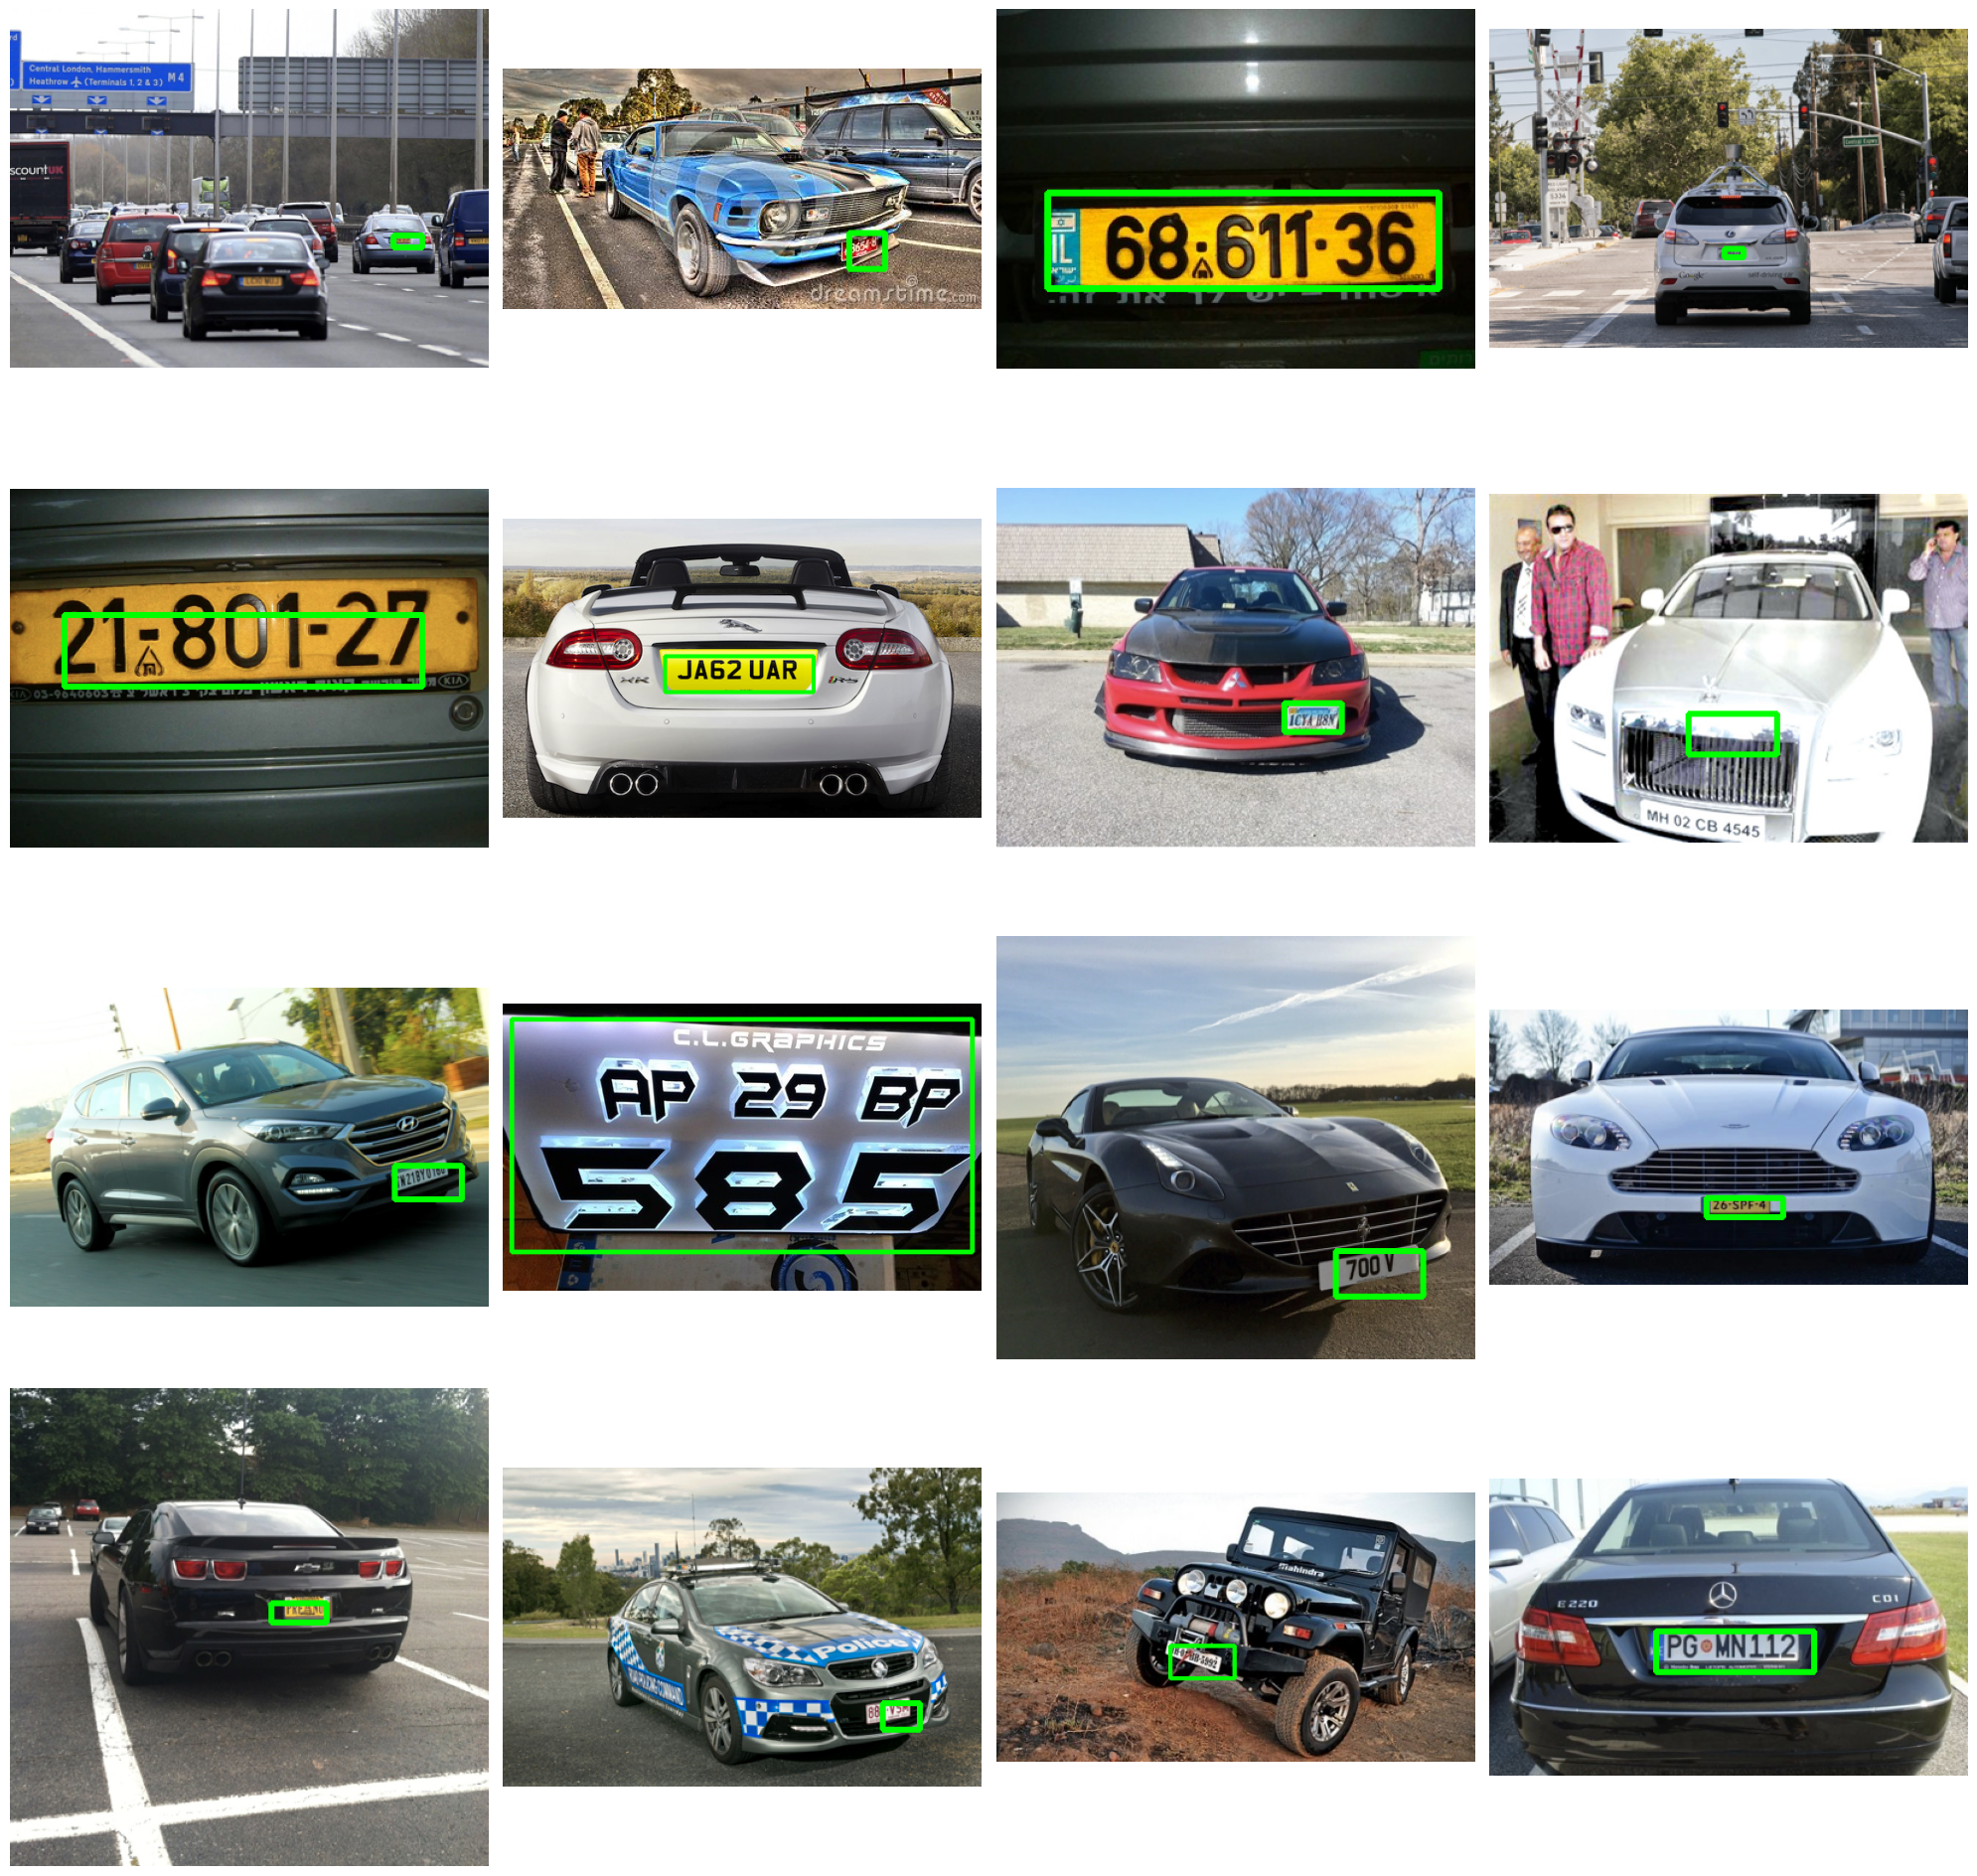

In [18]:
def plot_random_images(image_paths, num_images=16):
    selected_images = random.sample(image_paths, num_images)
    
    num_rows = num_images // 4
    fig, axs = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
    
    for i, image_path in enumerate(selected_images):
        row = i // 4
        col = i % 4
        
        image_with_box = object_detection(image_path)
        
        axs[row, col].imshow(cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB))
        axs[row, col].axis('off')
        
    plt.tight_layout()
    plt.show()

image_paths = [os.path.join(IMAGE_PATH, filename) for filename in os.listdir(IMAGE_PATH)]

plot_random_images(image_paths, num_images=16)

In [20]:
def predict_time(image_paths, num_images=100):
    start_time = time.time()

    for path in random.sample(image_paths, num_images):
        image_arr_224 = img_to_array(load_img(path, target_size=(224, 224))) / 255.0
        test_arr = image_arr_224.reshape(1, 224, 224, 3)
        model.predict(test_arr)

    end_time = time.time()
    elapsed_time = end_time - start_time
    return elapsed_time

prediction_time = predict_time(image_paths)
print("Tempo total de predição para 100 imagens aleatórias: {:.2f} segundos".format(prediction_time))

Tempo total de predição para 100 imagens aleatórias: 6.48 segundos
